## Generalised Perceptron

Binary classification based on MNIST and Fashion MNIST data. 

It restricts the classification problem to two classes, selects them from the (Fashion-)MNIST dataset, splits it up into a train and test part, does normalisation and then trains a binary classification (logistic regression) to learn to differentiate between the two categories.

Both datasets consist of images with 28x28 = 784 pixel each. The features refer to these pixel values of the images.

You can choose MNIST or Fashion-MNIST data in cell [2]

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from utils import read_data, plot_img, plot_tiles, plot_error, plot_cost 

In [3]:
#note the path in read_data for the data, which points to ../01.learning-optimization/data
#data is MNIST or fashionMNIST
x, y, labels_map = read_data('fashionMNIST', storage_path='../01.learning-optimization/data') 

data is fashionMNIST, shape of x is (70000, 28, 28)
 , shape of y is (70000,)


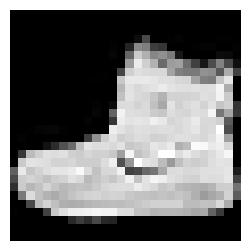

In [4]:
plot_img(x[0])

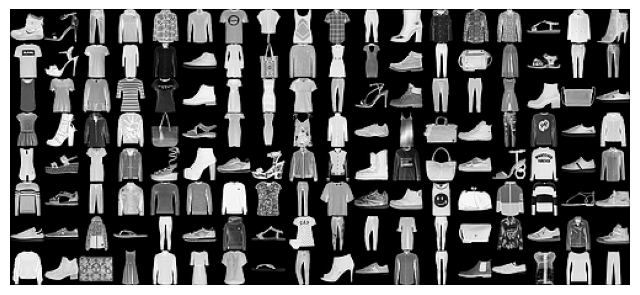

In [5]:
#append rows x cols tiles of images
rows = 8
cols = 18
#figure size can be set
fig_size = [8,8]

plot_tiles(x, rows, cols, fig_size)

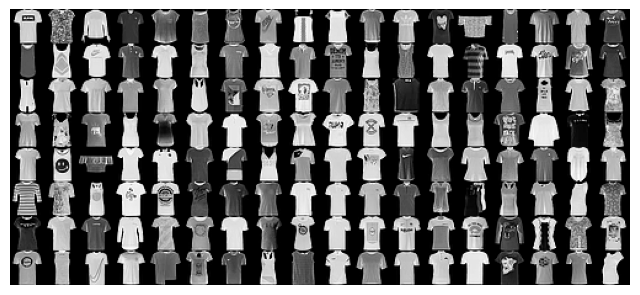

T-Shirt


In [6]:
#choose a given class 0..9
digit  = 0

plot_tiles(x[y == digit,:], rows, cols, fig_size)
print(labels_map[digit])

In [7]:
#select the two classes for your training and test set, select train and test split and to normalization
def prepare_data(class_1, class_2, train_size=0.8, min_max_normalise=1, flatten=1):
    """
    prepare the data for training

    Arguments:
    class_1 -- first class ('True') to select
    class_2 -- second class ('False') to select
    train_size -- fraction of train image size
    min_max_normalise -- whether to do min-max-normalisation (1) or rescaling (0)
    flatten -- whether to flatten the 28x28 image to single row
    """
    
    #select the digit
    x_sel_1 = x[y == class_1,:]
    x_sel_2 = x[y == class_2,:]

    #append the x data
    x_sel = np.append(x_sel_1, x_sel_2, 0)
    #construct y-data (class_1 is 'True')
    y_sel = np.append(np.ones((x_sel_1.shape[0],1)),
                      np.zeros((x_sel_2.shape[0],1)), 0)

    #do train and test split
    num_samples = x_sel.shape[0]
    max_train_ind = int(train_size*num_samples)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    x_train = x_sel[indices[:max_train_ind]]
    x_test = x_sel[indices[max_train_ind:]]
    
    y_train = y_sel[indices[:max_train_ind]]
    y_test = y_sel[indices[max_train_ind:]]

    #perform normalisation, take care of converting data type to float!
    xmax, xmin = np.max(x_train), np.min(x_train)
    
    if min_max_normalise:
        x_train = 2*(x_train.astype(float) - xmin) / (xmax - xmin) - 1
        x_test = 2*(x_test.astype(float) - xmin) / (xmax - xmin) - 1
    else:
        x_train = x_train.astype(float) / xmax 
        x_test = x_test.astype(float) / xmax 

    if flatten:
        m = x_train.shape[0]
        x_train = x_train.reshape([m,-1])
        m = x_test.shape[0]
        x_test = x_test.reshape([m,-1])
    
    return x_train, x_test, y_train, y_test

### Class NeuralNetwork

This class constructs a generalised perceptron. Cost function can be either MSE or CE (chosen in constructor). The method $propagate()$ returns the prediction $$ \hat{y}^{(i)}=h_\theta(\mathbf{x}^{(i)}) $$ on the input data (can be a n x 784 matrix of n images) and $back\_propagate()$ determines the gradients of the cost function with respect to the parameters (weights and bias) $$ \nabla_{\mathbf{\theta}} J(\mathbf{\theta}) $$
The method $gradient\_descend()$ finally does the correction of the parameters with a step in the negative gradient direction, weighted with the learning rate $$\alpha$$

In [9]:
class NeuralNetwork:
    """
    NN class handling the layers and doing all propagation and back-propagation steps
    """
    cost_MSE = 0
    cost_CE = 1
    
    def __init__(self, cost_function=cost_MSE, random_std = 0, size_in = 784):
        """
        constructor

        Arguments:
        cost_function -- can be cost_MSE (0, default) or cost_CE (1)
        random_std -- std for initialisation of weight (default is 0)
        size_in -- size of input image
        """
        self.size_in = size_in

        self.cost_function = cost_function
        
        #initialize weights and bias (zero or random)
        self.initialise_weights(random_std)
        
        # result array for cost and error of training and validation set
        self.result_data = np.array([])
        self.result_data_dL = np.array([])
        
        #we keep a global step counter, thus that optimise can be called 
        #several times with different settings
        self.epoch_counter = 0 

        
    def initialise_weights(self, random_std):
        """
        initialize weights and bias (if random_std == 0 all weights are zero)
        """ 
        self.w = random_std*np.random.randn(self.size_in,1)
        self.b = 0
    
    
    def propagate(self, x):
        """
        predicted outcome for x
        """
        z = x @ self.w + self.b
        y_pred = self.activation_function(z)
                    
        return y_pred

    
    def activation_function(self, z):
        """
        apply activation function
        """
        return 1/(1+np.exp(-z))
    
    
    def back_propagate(self, x, y_pred, y):
        """
        calculates the gradients of cost function wrt w and b
        """
        #abbreviation
        m = x.shape[0]
        
        if self.cost_function == self.cost_MSE:
            self.grad_w = x.T @ (y_pred * (1 - y_pred) * (y_pred - y)) / m
            self.grad_b = np.mean((y_pred * (1 - y_pred) * (y_pred - y)), 0)
        else:  
    ### START YOUR CODE ###

            # Cross-Entropy Loss (Binary)
            self.grad_w = x.T @ (y_pred - y) / m
            self.grad_b = np.mean(y_pred - y, axis=0)

        
    ### END YOUR CODE ###
    
    
    def gradient_descend(self, alpha):
        """
        applies gradient descend step to w and b
        """
        self.w -= alpha * self.grad_w
        self.b -= alpha * self.grad_b
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]
        
        res = np.round(y_pred)        
        error = np.sum(np.abs(res - y)) / m 

        return error
    
    
    def cost_funct(self, y_pred, y):
        """
        calculates the cost function
        """
        m = y.shape[0]
        
        if self.cost_function == self.cost_MSE:
            cost = np.sum((y_pred - y)**2)/(2*m)
        else:
     ### START YOUR CODE ###
            
            # Cross-Entropy Loss (Binary)
            cost = -np.sum(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8)) / m
            
     ### END YOUR CODE ###           
                            
        return cost   
    
    
    def append_result(self):
        """
        append cost and error data to output array
        """
        # determine cost and error functions for train and validation data
        y_pred_train = self.propagate(self.data['x_train'])
        y_pred_val = self.propagate(self.data['x_val'])

        res_data = np.array([[self.cost_funct(y_pred_train, self.data['y_train']), 
                              self.calc_error(y_pred_train, self.data['y_train']),
                              self.cost_funct(y_pred_val, self.data['y_val']), 
                              self.calc_error(y_pred_val, self.data['y_val'])]])
        
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        #increase epoch counter here (used for plot routines below)
        self.epoch_counter += 1 
        
        return res_data
    
    
          
    def optimise(self, data, epochs, alpha, debug=0):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        alpha -- learning rate
        debug -- False (default)/True; get info on gradient descend step
        """
        #access to data from other methods
        self.data = data
        
        # save results before 1st step
        if self.epoch_counter == 0:
            res_data = self.append_result()

        for i0 in range(0, epochs):            
            y_pred = self.propagate(data['x_train'])
            self.back_propagate(data['x_train'], y_pred, data['y_train'])
            self.gradient_descend(alpha)
          
            res_data = self.append_result()
                      
            if debug and np.mod(i0, debug) == 0:
                print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
                                          % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))

        if debug:
            print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
                  % (self.epoch_counter-1, res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3]))
    

### Sample execution of Neural Network

The cell below shows how to use the class NeuralNetwork and how to perform the optimisation. The training and test data is given as dictionary in the call to the method $optimise()$. This method can be called several times in a row with different arguments.

classes 'T-Shirt'[0] and 'Pullover'[2] chosen
784
Training Set: 10080 samples
Validation Set: 1120 samples
Test Set: 2800 samples
784
result after 1 epochs, train: cost 0.11019, error 0.34107 ; validation: cost 0.11278, error 0.33304
result after 51 epochs, train: cost 0.02416, error 0.05972 ; validation: cost 0.02899, error 0.06696
result after 101 epochs, train: cost 0.02060, error 0.04980 ; validation: cost 0.02532, error 0.05982
result after 151 epochs, train: cost 0.01907, error 0.04623 ; validation: cost 0.02391, error 0.05536
result after 201 epochs, train: cost 0.01813, error 0.04395 ; validation: cost 0.02311, error 0.05536
result after 251 epochs, train: cost 0.01748, error 0.04226 ; validation: cost 0.02256, error 0.05357
result after 301 epochs, train: cost 0.01699, error 0.04147 ; validation: cost 0.02214, error 0.05179
result after 351 epochs, train: cost 0.01660, error 0.04048 ; validation: cost 0.02180, error 0.04911
result after 400 epochs, train: cost 0.01628, error 0

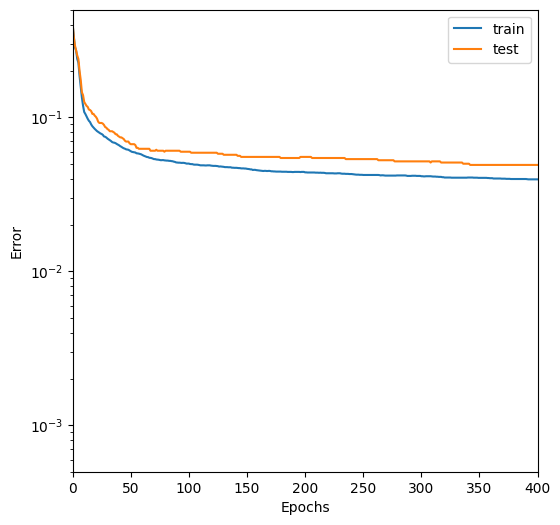

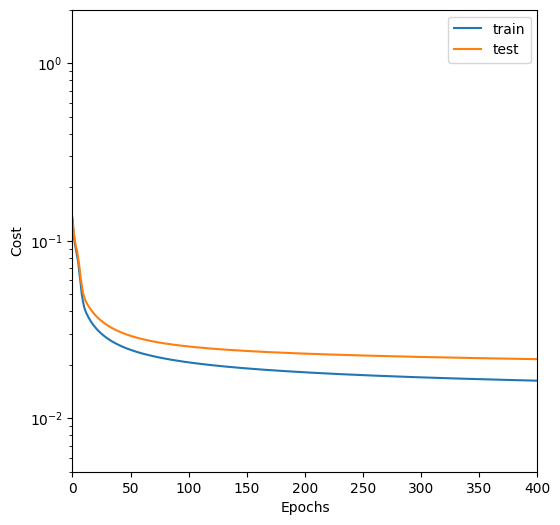

In [11]:
from sklearn.model_selection import train_test_split

#choose the categories
class_1 = 0
class_2 = 2
print('classes %r[%r] and %r[%r] chosen' % (labels_map[class_1], class_1, labels_map[class_2], class_2))

x_train, x_test, y_train, y_test = prepare_data(class_1, class_2, train_size=0.8, min_max_normalise=0, flatten=1)

print(len(x_train[0])) #checking information

### START YOUR CODE ###
           
#further split in train and validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, shuffle=True)

# Print dataset sizes
print(f"Training Set: {x_train.shape[0]} samples")
print(f"Validation Set: {x_val.shape[0]} samples")
print(f"Test Set: {x_test.shape[0]} samples")

# Check first training sample size
print(len(x_train[0]))  # Verifying input shape consistency

#data is arranged as dictionary with quick access through respective keys
data = {
    'x_train': x_train, 'y_train': y_train,  
    'x_val': x_val, 'y_val': y_val,  
    'x_test': x_test, 'y_test': y_test  
}

### END YOUR CODE ###     

NNet = NeuralNetwork(cost_function=0, random_std = 0.2, size_in = 784)

NNet.optimise(data, 400, 0.5, debug=50)

#NNet.optimise(data, 200, 0.2, debug=50)

plot_error(NNet)
plot_cost(NNet)

(114, 784)


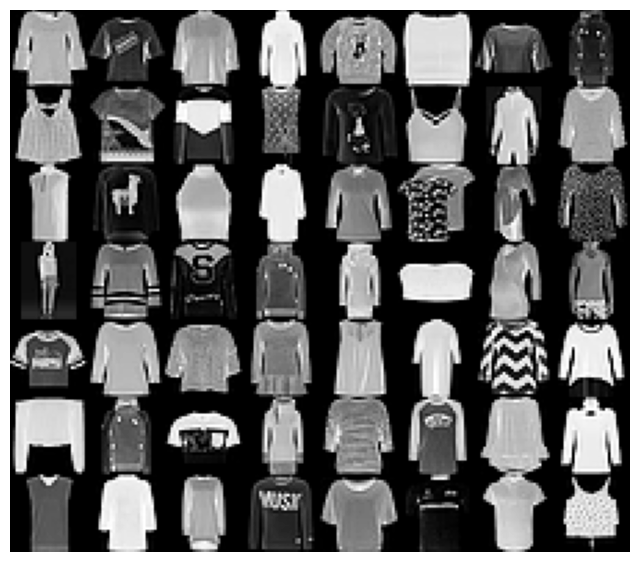

[[1 1 1 0 0 1 1 0]
 [1 1 0 1 0 1 0 1]
 [0 0 1 0 1 1 0 1]
 [0 0 0 0 0 1 1 1]
 [1 0 1 1 1 0 1 0]
 [1 0 1 0 0 1 1 1]
 [0 0 0 0 0 1 0 1]]


In [12]:
#analyse false classified training or test images
y_pred = np.round(NNet.propagate(x_test))
false_classifications = x_test[(y_pred != y_test)[:,0]]

print(false_classifications.shape)

#append rows x cols tiles of digits
rows = 7
cols = 8
#figure size can be set
fig_size = [8,8]

plot_tiles(false_classifications, rows, cols, fig_size)

#print the correct labels (for FashionMNIST)
if rows*cols < false_classifications.shape[0]:
    false_classifications_y = y_test[y_pred != y_test][:rows*cols]
else:
    false_classifications_y = np.append(y_test[y_pred != y_test], np.ones(rows*cols - false_classifications.shape[0])*-1)
print(false_classifications_y.reshape([cols,rows]).T.astype(int))

### k-fold cross validation

Below implement k-fold (test with k=5) cross validation and perform a test for MSE and CE cost an at least one pair of classes through determination of the validation error (for each fold) and its variance over the k folds. 

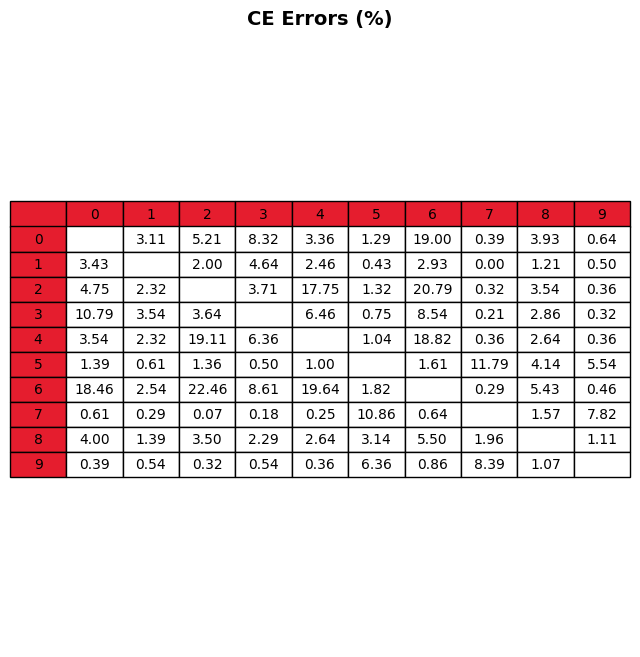

Best number of epochs: 1000 with validation error: 0.03482142857142857


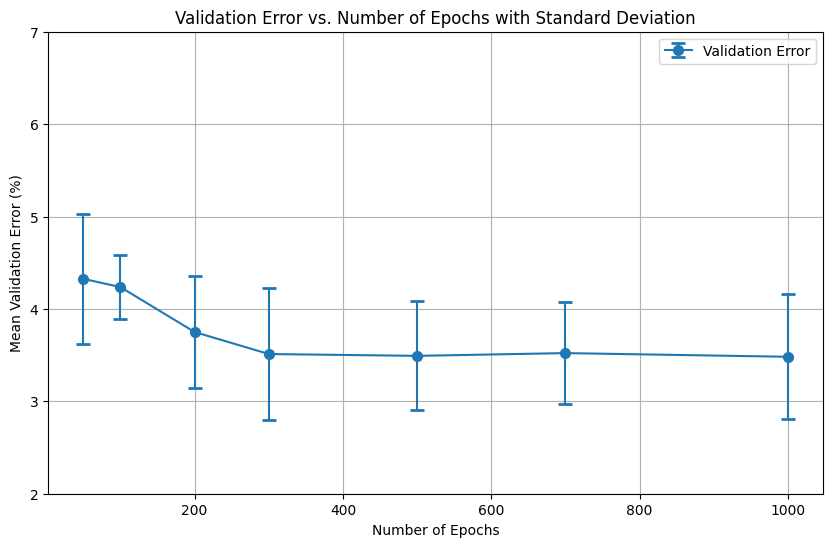

In [28]:
### START YOUR CODE ###
from sklearn.model_selection import KFold
from itertools import combinations

from concurrent.futures import ThreadPoolExecutor

cost_MSE = 0
cost_CE = 1
def process_pair(i, j, cost_function):
    """
    Processes a pair of classes (i, j) by training a neural network
    and computing the test error rate.

    Arguments:
    i -- First class
    j -- Second class
    cost_function -- Cost function type (0 for MSE, 1 for Cross-Entropy)

    Returns:
    Tuple (i, j, error_rate)
    """
    if i == j:
        return (i, j, 0.0)

    # Print the classes being processed
    #print(f"Processing Classes: {i} vs {j}")

    # Prepare Data
    x_train, x_test, y_train, y_test = prepare_data(i, j, train_size=0.8, min_max_normalise=1, flatten=1)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, shuffle=True)

    # Create data dictionary
    data = {
        'x_train': x_train, 'y_train': y_train,  
        'x_val': x_val, 'y_val': y_val,  
        'x_test': x_test, 'y_test': y_test  
    }

    # Train Neural Network
    NNet = NeuralNetwork(cost_function = 1, random_std = 0.2, size_in =784)
    NNet.optimise(data, 100, 0.05, debug=0)

    # Plot error and cost
    #plot_error(NNet)
    #plot_cost(NNet)

    # Compute error rate
    y_pred = np.round(NNet.propagate(data['x_test']))
    data_y_test = data['y_test'][:, 0]
    y_pred_test = y_pred[:, 0]
    false_y = data_y_test[(y_pred_test != data_y_test)].shape[0]
    error_rate = false_y / len(data_y_test)

    return (i, j, error_rate)

    
def calculate_error_for_all_classes(const_function=cost_CE):
    array_10x10 = np.zeros((10, 10))

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_pair, i, j, const_function) for i in range(10) for j in range(10) if i != j]

        for future in futures:
            i, j, error = future.result()
            array_10x10[i, j] = error

    return array_10x10.astype(float)

def display_table_1(array_10x10, title):
    array_11x11 = np.zeros((11, 11))
    array_11x11[1:,1:] = 100*array_10x10
    formatted_array = [[f"{val:.2f}" if i > 0 and j > 0 else "" for j, val in enumerate(row)]
                       for i, row in enumerate(array_11x11)]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')  
    ax.set_title(title, fontsize=14, fontweight="bold", pad=5)
    
    table = ax.table(cellText=formatted_array, loc='center', cellLoc='center', cellColours=[['white']*11]*11)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    table[0,0].get_text().set_text("")
    
    for k in range(11): 
        table[(0, k)].set_facecolor('#e51d2e') 
        table[(k, 0)].set_facecolor('#e51d2e')
        table[(k, k)].get_text().set_text("")
        if k < 10:
            table[0, k+1].get_text().set_text(k)
            table[k+1, 0].get_text().set_text(k)

    plt.show()


ce_errors = calculate_error_for_all_classes(cost_CE)
display_table_1(ce_errors, "CE Errors (%)")

## K-FOLD CROSS-VALIDATION PART

from sklearn.model_selection import KFold, train_test_split

# Define k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define hyperparameter search space for number of epochs
epochs_list = [50, 100, 200, 300, 500, 700, 1000]

# Store results
cv_results = {}
cv_results2 = {}

# Loop over different numbers of epochs
for epochs in epochs_list:
    fold_scores = []

    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(x_train):
        # Split data into training and validation
        x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Create data dictionary for the fold
        data_fold = {
            'x_train': x_fold_train, 'y_train': y_fold_train,
            'x_val': x_fold_val, 'y_val': y_fold_val,
            'x_test': x_test, 'y_test': y_test
        }

        # Initialize and train the Neural Network
        NNet = NeuralNetwork(cost_function=1, random_std=0.2, size_in=784)
        NNet.optimise(data_fold, epochs, alpha=0.5, debug=0)

        # Compute validation error using propagate
        y_pred = np.round(NNet.propagate(x_fold_val))  # Make predictions
        y_val_actual = y_fold_val[:, 0]  # Extract actual values
        y_pred_val = y_pred[:, 0]  # Extract predicted values

        # Compute misclassification rate
        false_y = y_val_actual[(y_pred_val != y_val_actual)].shape[0]
        fold_score = false_y / len(y_val_actual)
        fold_scores.append(fold_score)

    # Store the mean validation error across folds
    cv_results[epochs] = fold_scores
    cv_results2[epochs] = np.mean(fold_scores)

# Find the best number of epochs (minimum misclassification rate)
best_epochs = min(cv_results2, key=cv_results2.get)
print(f"Best number of epochs: {best_epochs} with validation error: {cv_results2[best_epochs]}")

## VISUALISATION

# cv_results contains lists of validation errors per epoch
epochs = sorted(cv_results.keys())
mean_errors = [np.mean(cv_results[epoch]) * 100 for epoch in epochs]  # Convert to percentage
std_errors = [np.std(cv_results[epoch], ddof=1) * 100 for epoch in epochs]  # Convert to percentage

# Plot mean validation error with standard deviation
plt.figure(figsize=(10, 6))
plt.errorbar(
    epochs, mean_errors, yerr=std_errors, fmt='-o', capsize=5, capthick=2, 
    elinewidth=1.5, markeredgewidth=2, label="Validation Error"
)
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Validation Error (%)")  # Update label to show percentage
plt.title("Validation Error vs. Number of Epochs with Standard Deviation")
plt.ylim(2, 7)  # Set y-axis limits between 2% and 7%
plt.legend()
plt.grid(True)
plt.show()


### END YOUR CODE ###